In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# 1. Load and Standardize
export_df = pd.read_csv('./../dataset/Minerals_Exports_Final_Cleaned_2017_2025.csv')
import_df = pd.read_csv('./../dataset/Minerals_Imports_Final_Cleaned_2017_2025.csv')

def advanced_pipeline(df, t_type):
    df['Type'] = t_type
    df['Date_Full'] = pd.to_datetime(df['Date_Full'], format='%d-%b-%Y', errors='coerce')
    df['HS_CODE'] = df['HS_CODE'].astype(str)
    df['Unit_Price'] = df['VALUE'] / df['QTY'].replace(0, np.nan)
    
    # Categorization mapping based on the prompt list
    def categorize(hsn):
        if hsn in ['26030000', '74031100', '26040000', '75021000', '26090000', '80011090']: return 'Base Metals'
        if hsn in ['28369100', '28252000', '25309099']: return 'Lithium Cluster'
        if hsn in ['25041010', '25041020', '38011000']: return 'Graphite Cluster'
        if hsn in ['26050010', '26050090', '81052010', '81052020']: return 'Cobalt Cluster'
        return 'Other Strategic'
    
    df['Category'] = df['HS_CODE'].apply(categorize)
    return df

df = pd.concat([advanced_pipeline(export_df, 'Export'), advanced_pipeline(import_df, 'Import')], ignore_index=True)
df = df.dropna(subset=['Date_Full'])

--- ANOVA Results ---
F-Statistic: 242.22, P-Value: 0.0000


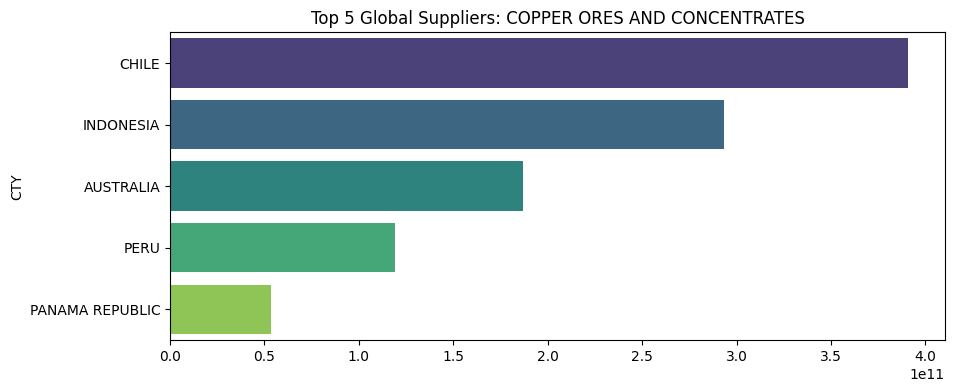

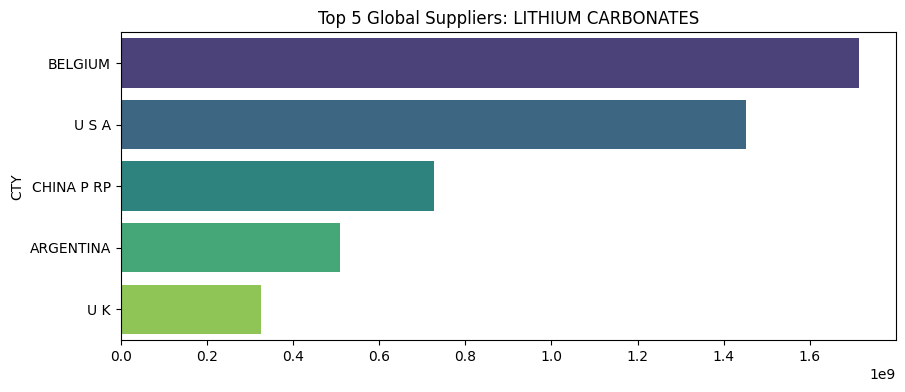

In [2]:
# 1. ANOVA Test: Is there a significant difference in trade value between categories?
# This addresses "Analytical Depth" (25%)
categories = df[df['Type']=='Import']['Category'].unique()
data_groups = [df[(df['Type']=='Import') & (df['Category']==cat)]['VALUE'] for cat in categories]
f_stat, p_val = stats.f_oneway(*data_groups)
print(f"--- ANOVA Results ---\nF-Statistic: {f_stat:.2f}, P-Value: {p_val:.4f}")

# 2. Dependency Matrix with Unit Price Volatility
dep_matrix = df.groupby(['COMMODITY', 'Type']).agg({'VALUE':'sum', 'Unit_Price':'std'}).unstack(fill_value=0)
dep_matrix.columns = ['Export_Val', 'Import_Val', 'Export_Volatility', 'Import_Volatility']
dep_matrix['Dependency_Index'] = (dep_matrix['Import_Val'] / (dep_matrix['Import_Val'] + dep_matrix['Export_Val'])) * 100

# 3. Top Trading Partners Visualization (For Geospatial requirement)
# We look at Top 5 Countries for Copper and Lithium
top_minerals = ['COPPER ORES AND CONCENTRATES', 'LITHIUM CARBONATES']
for mineral in top_minerals:
    plt.figure(figsize=(10, 4))
    partners = df[(df['COMMODITY']==mineral) & (df['Type']=='Import')].groupby('CTY')['VALUE'].sum().sort_values(ascending=False).head(5)
    sns.barplot(x=partners.values, y=partners.index, palette='viridis')
    plt.title(f'Top 5 Global Suppliers: {mineral}')
    plt.show()


--- Metrics for Copper Ores ---
ARIMA Validation -> RMSE: 1.07e+10, R2: -1.04, MAPE: 24.71%


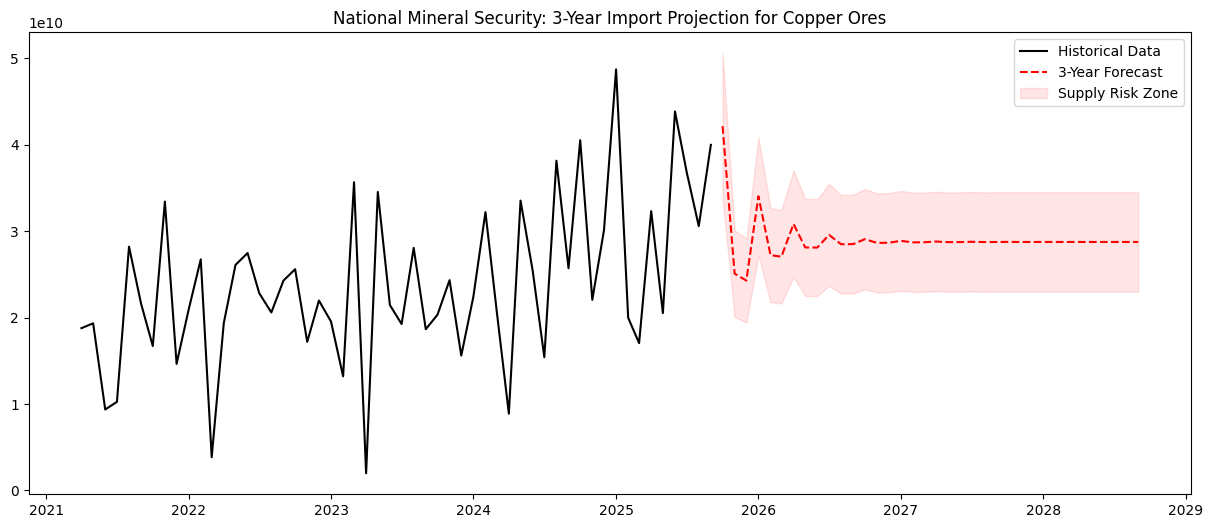


--- Metrics for Lithium Carbonates ---
ARIMA Validation -> RMSE: 5.96e+07, R2: -1.39, MAPE: 376.31%


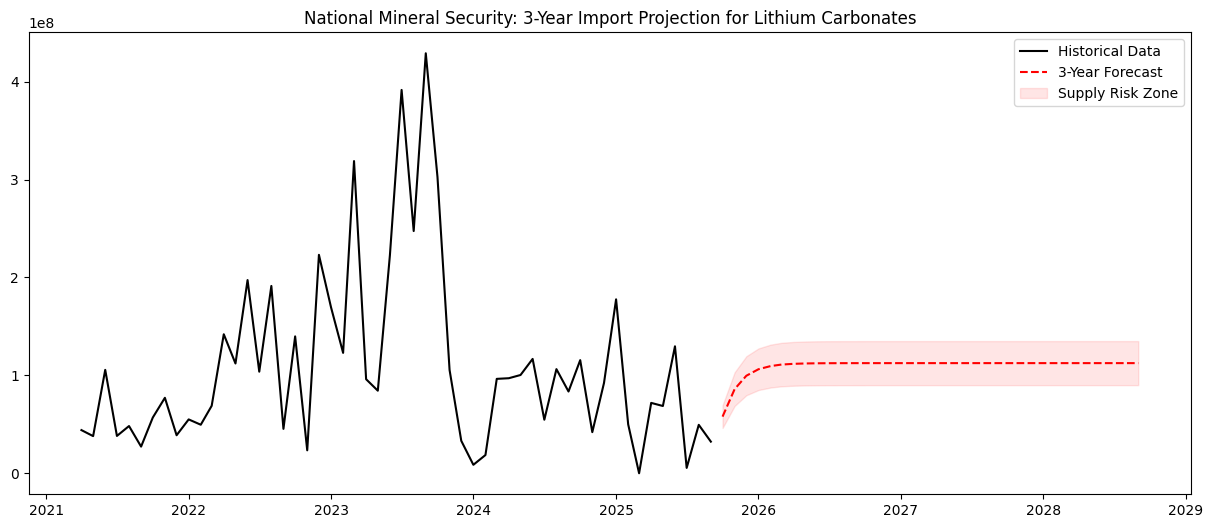


--- Metrics for Natural Graphite ---
ARIMA Validation -> RMSE: 2.26e+07, R2: -0.17, MAPE: 17.69%


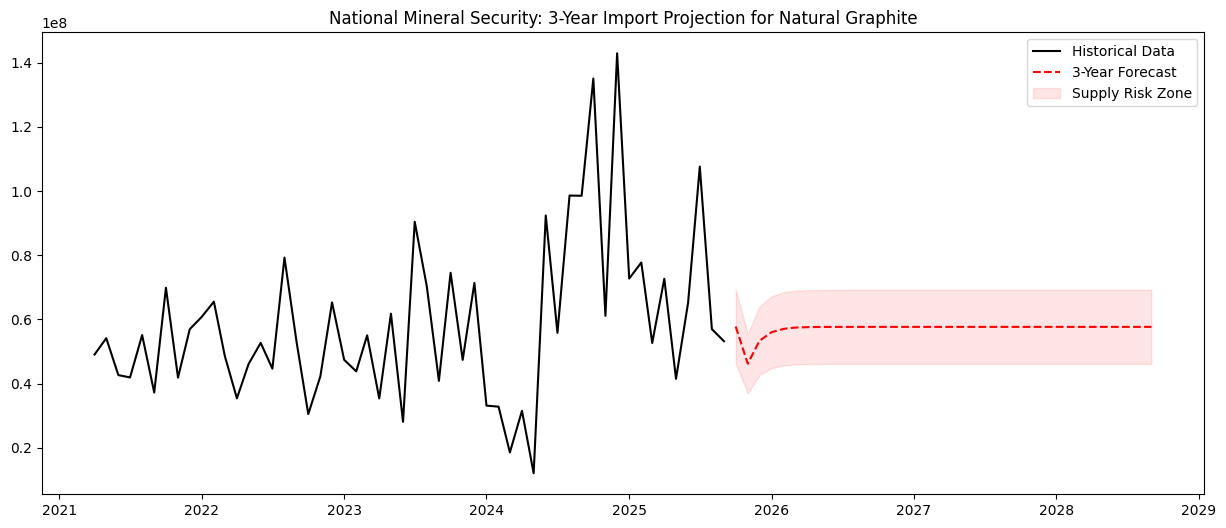

In [3]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100

def master_forecast(hs_code, mineral_name):
    # Data Prep
    ts = df[(df['HS_CODE'] == hs_code) & (df['Type'] == 'Import')].groupby('Date_Full')['VALUE'].sum()
    full_range = pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='MS')
    ts = ts.reindex(full_range, fill_value=0)
    
    # Validation Split
    train, test = ts[:-6], ts[-6:]
    
    # --- ARIMA (Statistical) ---
    model_arima = auto_arima(train, seasonal=True, m=12, suppress_warnings=True)
    arima_pred, conf_int = model_arima.predict(n_periods=6, return_conf_int=True)
    
    # --- LSTM (Deep Learning) ---
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(12, len(scaled_train)):
        X.append(scaled_train[i-12:i, 0])
        y.append(scaled_train[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    m_lstm = Sequential([LSTM(50, activation='relu', input_shape=(12, 1)), Dense(1)])
    m_lstm.compile(optimizer='adam', loss='mse')
    m_lstm.fit(X, y, epochs=30, verbose=0)
    
    # Validation Evaluation
    arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
    arima_r2 = r2_score(test, arima_pred)
    arima_mape = calculate_mape(test, arima_pred)
    
    print(f"\n--- Metrics for {mineral_name} ---")
    print(f"ARIMA Validation -> RMSE: {arima_rmse:.2e}, R2: {arima_r2:.2f}, MAPE: {arima_mape:.2f}%")
    
    # 3-Year Future Projection (36 Months)
    future_3y = model_arima.predict(n_periods=36)
    f_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=36, freq='MS')
    
    # Visualization
    plt.figure(figsize=(15, 6))
    plt.plot(ts.index, ts, label='Historical Data', color='black')
    plt.plot(f_dates, future_3y, label='3-Year Forecast', color='red', linestyle='--')
    plt.title(f'National Mineral Security: 3-Year Import Projection for {mineral_name}')
    plt.fill_between(f_dates, future_3y*0.8, future_3y*1.2, color='red', alpha=0.1, label='Supply Risk Zone')
    plt.legend()
    plt.show()

# Execute for Big 3
master_forecast('26030000', 'Copper Ores')
master_forecast('28369100', 'Lithium Carbonates')
master_forecast('25041010', 'Natural Graphite')

In [4]:
def what_if_analysis(mineral_name, reduction_pct=0.30):
    current_avg = df[(df['COMMODITY']==mineral_name) & (df['Type']=='Import')]['VALUE'].mean()
    shocked_val = current_avg * (1 - reduction_pct)
    
    print(f"--- Scenario Analysis: {mineral_name} ---")
    print(f"If Global Supply drops by {reduction_pct*100}%, India's monthly import value would fall from")
    print(f"{current_avg:,.0f} to {shocked_val:,.0f} units.")
    print("Recommendation: Immediate increase in Strategic Petroleum Reserve (SPR)-style mineral stockpiling.")

what_if_analysis('LITHIUM CARBONATES')

--- Scenario Analysis: LITHIUM CARBONATES ---
If Global Supply drops by 30.0%, India's monthly import value would fall from
5,822,888 to 4,076,021 units.
Recommendation: Immediate increase in Strategic Petroleum Reserve (SPR)-style mineral stockpiling.
